<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/05-GPUParallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Parallelism

> "Access to compute is not enough to train good neural networks. Researchers need to use a completely different paradigm where data and model weights are distributed across different devices — and sometimes even different computers." [4]  

GPUs (graphics processing units) have revolutionized high-performance computing, enabling tasks that were previously computationally prohibitive. Originally designed for gaming, GPUs were optimized for rendering complex graphics efficiently. Today, their parallel processing capabilities make them indispensable in fields such as scientific research, video processing, and machine learning [2]. This technological importance is reflected in Nvidia’s milestone of achieving a $2 trillion market capitalization, underscoring the role of GPUs in modern computing [1].

Central to the power of GPUs is parallelism, the ability to perform many calculations simultaneously. This feature allows GPUs to handle massive computational workloads with remarkable efficiency, particularly in domains requiring large-scale data processing or repetitive operations.

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Embed GIF</title>
    <style>
        .gif-container {
            text-align: center;
        }
        .gif-caption {
            font-size: 16px;
        }
    </style>
</head>
<body>
    <div class="gif-container">
        <img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*4K4CPA7-Y1HYPMQKFoCi5Q.gif" alt="Sample GIF">
        <p class="gif-caption">Figure from Medium [5], accessed 17/11/2024, showing the power of parallel processing with GPUs. The leftmost picture indicates serial processing.</p>
    </div>
</body>
</html>

## GPU vs CPU

A CPU core is a single processing unit within the CPU that executes instructions sequentially [6]. CPUs typically have few cores (4 to 24 [13]), while GPUs feature many more. For example, the Nvidia RTX 3090 features 10,496 cores [7]. GPU cores are smaller, less powerful, and have less memory than CPU cores but excel at handling repetitive tasks in parallel [8].

CPUs are optimized for sequential task execution and can quickly switch between varied instructions, making them versatile for general-purpose tasks. GPUs, in contrast, are designed for parallelism. We say that they use their thousands of *cores* to process many **threads** of a task simultaneously. This design makes GPUs especially effective for data-heavy operations, such as rendering graphics or training machine learning models.

<html>
<head>
    <title>Image with Caption</title>
</head>
<body>
    <div style="text-align: center;">
        <img src="https://www.cgdirector.com/wp-content/uploads/media/2021/06/Differences-between-GPU-and-CPU-cores.jpg"
             alt="Differences between GPU and CPU cores"
             style="width: 90%; max-width: 500px; height: auto;">
        <p>Differences between GPU and CPU cores, taken from [8], accessed 17/11/2024.</p>
    </div>
</body>
</html>

## Data Parallelism: Divide and Conquer
GPU parallelism is based on the SIMD (Single Instruction, Multiple Data) model [14], a technique where the same operation is applied to multiple data elements at the same time. This allows GPUs to execute the same instruction across multiple data points simultaneously, a concept known as **data parallelism**. This allows GPUs to process vast amounts of data in parallel, which dramatically speeds up computations compared to traditional CPU-based approaches.

This is particularly effective for applications that process large datasets and where the same operation needs to be applied repeatedly to each data element. Examples include scientific simulations, image and video processing, and machine learning tasks such as training deep neural networks, which involve applying the same mathematical operations across large sets of data (e.g., matrix multiplications, convolutions).

<!DOCTYPE html>
<html>
<head>
    <title>Image with Caption</title>
</head>
<body>
    <div style="text-align: center;">
        <img src="https://miro.medium.com/v2/resize:fit:1400/1*a9zrtdqLQbBATH0EBmheFQ.png"
             alt="Sample Image"
             style="width: 50%; max-width: 400px; height: auto;">
        <p>Image showing data parallelism: taken from [10], accessed 17/11/2024.</p>
    </div>
</body>
</html>

In contrast, traditional CPU parallelism typically involves executing different instructions on different tasks or data, which makes CPUs well-suited for tasks that require more complex decision-making or varied instructions. However, when it comes to applications that involve repeated identical computations on large datasets, the GPU’s design proves far more efficient. Further details, including how data parallelism helps with efficient weight updates with gradient accumulation can be seen in [4, 10].

Another way in which GPUs can employ parallelism is *model parallelism*.

# Model Parallelism: Sharing the Load

Model parallelism is a parallel computing technique where different parts or sections of a neural network model run on different devices or nodes. This approach is particularly beneficial when dealing with very large models that don’t fit entirely within the memory of a single GPU. Instead of dividing the data, as in data parallelism, model parallelism divides the model itself. This ensures that even models with a vast number of parameters can be trained by leveraging the combined memory of multiple GPUs.

<!DOCTYPE html>
<html>
<head>
    <title>Image with Caption</title>
</head>
<body>
    <div style="text-align: center;">
        <img src="https://images.ctfassets.net/xjan103pcp94/3dXMEU8MDlwyreIB7bFMwI/9c755e4a7c5aa9f314c49cbeac21ab4c/blog-what-is-distributed-training-data-vs-model-parallelism.png"
             alt="Distributed Training: Data vs Model Parallelism"
             style="width: 60%; max-width: 500px; height: auto;">
        <p>Distributed Training: Data vs Model Parallelism. Taken from [11], accessed 17/11/2024.</p>
    </div>
</body>
</html>

The biggest manufacturers of GPUs, NVIDIA, AMD and Intel, have different ways they structure their GPUs to allow effective parallelism. Efficient execution on GPUs also requires careful consideration of memory management. Optimizations such as memory coalescing, where memory accesses are grouped together to reduce latency, and kernel optimization, where the computational workload is streamlined, are essential to maximizing performance. These optimizations help mitigate the challenges associated with memory bandwidth limitations and synchronization overhead, which are common bottlenecks in parallel computing environments.


# Demonstration

We demonstrate the power of parallelism by using a CPU and GPU to perform matrix addition, and comparing the time taken by each. We focus on small square matrices with 10 rows to 100 rows, as well as larger matrices with at least 10 times as many rows and columns as the smaller ones.

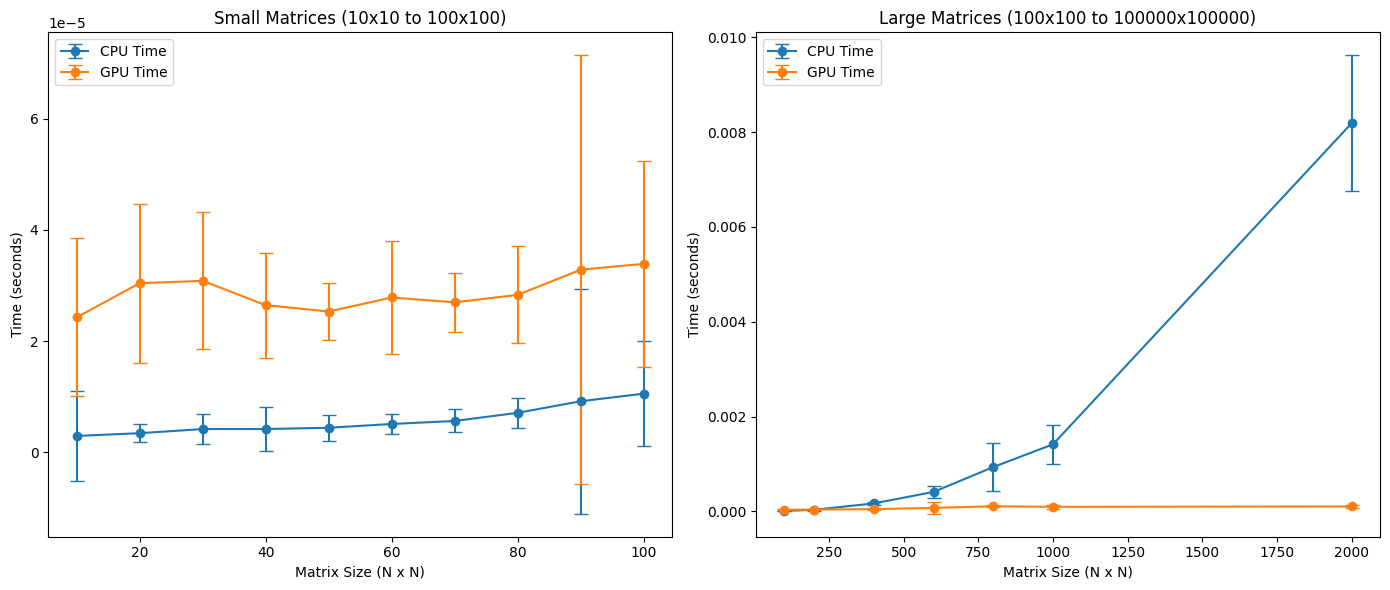

In [9]:
import cupy as cp
import numpy as np
import time
import matplotlib.pyplot as plt

# Function to measure the time for CPU operation
def cpu_addition(a, b):
    return a + b

# Function to measure the time for GPU operation
def gpu_addition(a, b):
    return cp.add(a, b)

# Define two sets of matrix sizes for small and large matrices
small_matrix_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
large_matrix_sizes = [100, 200, 400, 600, 800, 1000, 2000]

# Lists to store the mean times and standard deviations for plotting
cpu_times_small = []
gpu_times_small = []
cpu_std_small = []
gpu_std_small = []

cpu_times_large = []
gpu_times_large = []
cpu_std_large = []
gpu_std_large = []

# Function to run the experiment and collect times for a given set of matrix sizes
def run_experiment(matrix_sizes, cpu_times, gpu_times, cpu_std, gpu_std):
    for size in matrix_sizes:
        cpu_reps = []
        gpu_reps = []

        # Run 100 repetitions for each matrix size
        for _ in range(100):
            # Create random matrices on CPU
            a_cpu = np.random.rand(size, size)
            b_cpu = np.random.rand(size, size)

            # Measure CPU time
            start_time = time.time()
            cpu_addition(a_cpu, b_cpu)
            cpu_reps.append(time.time() - start_time)

            # Transfer arrays to GPU
            a_gpu = cp.asarray(a_cpu)
            b_gpu = cp.asarray(b_cpu)

            # Measure GPU time
            start_time = time.time()
            gpu_addition(a_gpu, b_gpu)
            gpu_reps.append(time.time() - start_time)

        # Compute mean and standard deviation for each size
        cpu_times.append(np.mean(cpu_reps))
        gpu_times.append(np.mean(gpu_reps))
        cpu_std.append(np.std(cpu_reps))
        gpu_std.append(np.std(gpu_reps))

# Run the experiment for small matrices (10x10 to 100x100)
run_experiment(small_matrix_sizes, cpu_times_small, gpu_times_small, cpu_std_small, gpu_std_small)

# Run the experiment for large matrices (100x100 to 100000x100000)
run_experiment(large_matrix_sizes, cpu_times_large, gpu_times_large, cpu_std_large, gpu_std_large)

# Plot the results side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for small matrices (10 to 100)
axs[0].errorbar(small_matrix_sizes, cpu_times_small, yerr=2 * np.array(cpu_std_small), label='CPU Time', fmt='o-', capsize=5)
axs[0].errorbar(small_matrix_sizes, gpu_times_small, yerr=2 * np.array(gpu_std_small), label='GPU Time', fmt='o-', capsize=5)
axs[0].set_xlabel('Matrix Size (N x N)')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('Small Matrices (10x10 to 100x100)')
axs[0].legend()
axs[0].grid(False)

# Plot for large matrices (100 to 100000)
axs[1].errorbar(large_matrix_sizes, cpu_times_large, yerr=2 * np.array(cpu_std_large), label='CPU Time', fmt='o-', capsize=5)
axs[1].errorbar(large_matrix_sizes, gpu_times_large, yerr=2 * np.array(gpu_std_large), label='GPU Time', fmt='o-', capsize=5)
axs[1].set_xlabel('Matrix Size (N x N)')
axs[1].set_ylabel('Time (seconds)')
axs[1].set_title('Large Matrices (100x100 to 100000x100000)')
axs[1].legend()
axs[1].grid(False)

plt.tight_layout()
plt.show()


For small matrices (10x10 to 100x100), we see that the CPU consistently outperforms the GPU. Both CPU and GPU times remain relatively constant, but the error bars indicate noticeable variability. This is likely due to the *synchronisation overhead* mentioned before.

Overall, we draw an insight that for small matrices, the GPU's parallelism is inefficient due to high overhead costs compared to the lightweight computation required.

On the other hand, for large Matrices (100x100 to 2000x2000), the CPU time increases sharply, following a near-quadratic trend in $N$ (expected since the matrix size is $N^2$). In the meantime, GPU time remains relatively constant, highlighting its scalability and ability to handle large workloads efficiently.

Hence, we note that the GPU dramatically outperforms CPU in terms of computation time and infer that for large matrices, the GPU's parallel architecture provides a significant advantage, reducing computation time and achieving better scalability.

**Remark on the cause of variability**: The error bars in both plots indicate variability in timings. This can be due to:
  - generation of random matrices,
  - system or hardware factors (e.g., memory access delays).
  - algorithmic factors (e.g., thread scheduling).

  We produce a table of the speed-up factors for the reader's interest.

In [12]:
# Calculate which is faster and the speedup factor
def compare_and_speedup(cpu_time, gpu_time):
    if cpu_time < gpu_time:
        return 'CPU', gpu_time / cpu_time
    else:
        return 'GPU', cpu_time / gpu_time

# Process small matrices
small_comparison = [compare_and_speedup(cpu, gpu) for cpu, gpu in zip(cpu_times_small, gpu_times_small)]
small_matrix_df = pd.DataFrame({
    'Matrix Size': small_matrix_sizes,
    'CPU Time (seconds)': cpu_times_small,
    'GPU Time (seconds)': gpu_times_small,
    'Faster (GPU/CPU)': [comp[0] for comp in small_comparison],
    'Speedup Factor': [comp[1] for comp in small_comparison],
})

# Process large matrices
large_comparison = [compare_and_speedup(cpu, gpu) for cpu, gpu in zip(cpu_times_large, gpu_times_large)]
large_matrix_df = pd.DataFrame({
    'Matrix Size': large_matrix_sizes,
    'CPU Time (seconds)': cpu_times_large,
    'GPU Time (seconds)': gpu_times_large,
    'Faster (GPU/CPU)': [comp[0] for comp in large_comparison],
    'Speedup Factor': [comp[1] for comp in large_comparison],
})

# Print the results
print("Speedup Table for Small Matrices (10x10 to 100x100):")
print(small_matrix_df)

print("\nSpeedup Table for Large Matrices (100x100 to 100000x100000):")
print(large_matrix_df)


Speedup Table for Small Matrices (10x10 to 100x100):
   Matrix Size  CPU Time (seconds)  GPU Time (seconds) Faster (GPU/CPU)  \
0           10            0.000003            0.000024              CPU   
1           20            0.000003            0.000030              CPU   
2           30            0.000004            0.000031              CPU   
3           40            0.000004            0.000026              CPU   
4           50            0.000004            0.000025              CPU   
5           60            0.000005            0.000028              CPU   
6           70            0.000006            0.000027              CPU   
7           80            0.000007            0.000028              CPU   
8           90            0.000009            0.000033              CPU   
9          100            0.000011            0.000034              CPU   

   Speedup Factor  
0        8.288509  
1        8.891911  
2        7.401259  
3        6.347826  
4        5.753930  
5

We note that the GPU becomes faster from 400 x 400 matrices and provides a speed up of up to 80 x for 2000 x 2000 matrix addition. We can be reassured that GPUs will help us for our neural network fits, as the computations are much more complicated than matrix addition!

# Conclusion

The advantages of GPU parallelism are most evident in tasks that require processing large volumes of data with high computational demands. In our case, training a CNN is highly computationally intensive. GPUs dramatically accelerate these processes, reducing the time required for training models from days to hours. We have certainly not covered all there is to parallelism. A more technical tutorial, with details on how to minimise idle time of the GPU and ensure high and efficient GPU usage, is given in [12].

## References  

[1] ["Nvidia hits $2 trillion market cap as AI chips fuel growth."](https://www.theverge.com/2024/2/23/24080975/nvidia-ai-chips-h100-h200-market-capitalization) *The Verge*, February 23, 2024.  

[2] ["Harnessing Parallelism: How GPUs Revolutionize Computing."](https://medium.com/accredian/harnessing-parallelism-how-gpus-revolutionize-computing-597f3479d955) *Medium*, 2024.  

[3] "Why GPU Parallel Computing Matters to CEOs." *Accredian*, 2024.  

[4] ["Understanding GPU Parallelization in Deep Learning."](https://www.blopig.com/blog/2023/10/understanding-gpu-parallelization-in-deep-learning/) *Blopig Blog*, October 2023.  

[5] ["Differences Between GPU and CPU Cores."](https://www.cgdirector.com/wp-content/uploads/media/2021/06/Differences-between-GPU-and-CPU-cores.jpg) *CG Director*, June 2021.  

[6] ["The Difference Between GPUs and CPUs."](https://aws.amazon.com/compare/the-difference-between-gpus-cpus/#:~:text=GPUs%20excel%20in%20parallel%20processing,them%20through%20at%20high%20speed) *Amazon Web Services*.  

[7] ["Gradient Accumulation in Deep Learning."](https://kozodoi.me/blog/20210219/gradient-accumulation) *Kozodoi Blog*, February 2021.  

[8] ["Distributed Training: Data vs. Model Parallelism."](https://images.ctfassets.net/xjan103pcp94/3dXMEU8MDlwyreIB7bFMwI/9c755e4a7c5aa9f314c49cbeac21ab4c/blog-what-is-distributed-training-data-vs-model-parallelism.png) *EnCCS GPU Programming Guide*.  

[9] ["Introduction to GPU Concepts."](https://enccs.github.io/gpu-programming/4-gpu-concepts/) *ENCCS GPU Programming Guide*.  

[10] ["Can Modern CPUs Run in SIMT Mode Like a GPU?"](https://stackoverflow.com/questions/77445710/can-modern-cpus-run-in-simt-mode-like-a-gpu) *Stack Overflow*, 2024.  

[11] ["Intel Core i9 Processors."](https://www.intel.com/content/www/us/en/products/details/processors/core/i9/products.html) *Intel Official Website*.  

[12] [Technical Tutorial on GPU concepts.](https://enccs.github.io/gpu-programming/4-gpu-concepts/)
